<a href="https://colab.research.google.com/github/ditatteda/ML21_HW/blob/ditatteta_branch/HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

# **Download Data**


If the Google drive links are dead, you can download data from [kaggle](https://www.kaggle.com/c/ml2021spring-hw1/data), and upload data manually to the workspace.

In [1]:
!gdown --id '19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF' --output covid.train.csv
!gdown --id '1CE240jLm2npU-tdz81-oVKEF3T2yfT1O' --output covid.test.csv

# If success, the data will be stored under /content/
# There will be two files: covid.train.csv and covid.test.csv

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=19CCyCgJrUxtvgZF53vnctJiOJ23T5mqF
To: /content/covid.train.csv
100% 2.00M/2.00M [00:00<00:00, 225MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CE240jLm2npU-tdz81-oVKEF3T2yfT1O
To: /content/covid.test.csv
100% 651k/651k [00:00<00:00, 131MB/s]


## **Filepath**

There are two file paths:
* /content/covid.train.csv
* /content/covid.test.csv

In ML, we usually split 90% of training data for training and another 10% for validating.

In [2]:
filepath_train = "./covid.train.csv"
filepath_valid = "./covid.train.csv"    # data for validating, which is from the training data
filepath_test = "./covid.test.csv"

# note that in colab, our working directory is at /content/

# **Import Some Packages**

In [3]:
import csv
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

## **Dataset**

* We have three kinds of dataset: training, validating, and testing.
* We define a class to manipulate the three.

In [4]:
# Each row of training data is
#   40 states + day 1 (17 info + 1 positive-rate) + day 2 (17 info + 1 positive-rate) + day 3 (17 info + 1 positive-rate)
#   row 1: one-hot-vector of states, Feb 1, Feb 2, Feb 3
#   row 2: one-hot-vector of states, Feb 2, Feb 3, Feb 4
#   row 3: one-hot-vector of states, Feb 3, Feb 4, Feb 5
#   ...

# Each row of testing data is
#   40 states + day 1 (17 info + 1 positive-rate) + day 2 (17 info + 1 positive-rate) + day 3 (17 info)
#   row 1: one-hot-vector of states, Feb 1, Feb 2, Feb 3
#   row 2: one-hot-vector of states, Feb 2, Feb 3, Feb 4
#   row 3: one-hot-vector of states, Feb 3, Feb 4, Feb 5
#   ...

# Day 3's positive-rate is the one to be predicted.
# Features to feed = 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
features_lst = list(range(93))

In [26]:

class Dataset_Covid19(Dataset):

    def __init__(self, filepath, mode):

        # Three modes: traing, validating, and testing
        self.mode = mode

        # Read data into array
        # First row of data is the information of each column and first column of data
        #   is the index of rows, which should be discarded in the calculation.
        with open(filepath, "r") as fp:
            data = np.array(list(csv.reader(fp)))
            data = data[1:, 1:].astype(float)

        if mode == "test":
            # testing data
            # 893 x 93 (40 states + day 1 (18) + day 2 (18) + day 3 (17))
            self.data = torch.FloatTensor(data[:, features_lst])

        elif mode in ["train",  "valid"]:
            # training data
            # 2700 x 94 (40 states + day 1 (18) + day 2 (18) + day 3 (17+1))
            # Split the training data into 9:1 portion; 9 for training,
            #   the other for validating.

            # save day 3's positive-rate to labels, and the remaining to data
            labels = data[:, -1]
            data = data[:, features_lst]

            # construct an indices list to hold the selected row indices
            indices_lst = []

            '''if mode == "train":
              indices_lst = [i for i in range(len(data)) if i % 10 != 0]
            else:
              indices_lst = [i for i in range(len(data)) if i % 10 == 0]'''

            # loop through each state
            for s in range(40):

                # find the begin index for the state
                bgnIdx_of_state = int(np.nonzero( data[:, s])[0][0])

                # count the number of data of the state
                samples_of_state = int(data[:, s].sum())

                # splitting index for training and validating
                splitIdx = bgnIdx_of_state + int(samples_of_state * 0.9 + 1)

                if mode == "train":
                    indices_lst += list(range(bgnIdx_of_state, splitIdx))

                elif mode == "valid":
                    indices_lst += list(range(splitIdx, bgnIdx_of_state + samples_of_state))

            self.label = torch.FloatTensor(labels[indices_lst])
            self.label = torch.unsqueeze(self.label, 1)
            self.data = torch.FloatTensor(data[indices_lst])

        # normalization of features (column index from 40 to 93)
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim=0, keepdim=True)) \
            / self.data[:, 40:].std(dim=0, keepdim=True)

        self.dim = self.data.shape[1]
        print(f"Dataset: {self.mode}\nSamples: {self.data.shape[0]}\nDimension of each sample: {self.dim}")

    def __getitem__(self, index):
        # Returns one sample at a time
        if self.mode in ['train', 'valid']:
            # For training
            return self.data[index], self.label[index]
        else:
            # For testing (no target)
            return self.data[index]

    def __len__(self):
        return len(self.data)

## **Data Loader**

In [21]:
BATCH_SIZE = 270

# adjust num_workers

train_loader = DataLoader(
    Dataset_Covid19(filepath_train, "train"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
valid_loader = DataLoader(
    Dataset_Covid19(filepath_valid, "valid"),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    Dataset_Covid19(filepath_test,"test"),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Dataset: train
Samples: 2460
Dimension of each sample: 93
Dataset: valid
Samples: 240
Dimension of each sample: 93
Dataset: test
Samples: 893
Dimension of each sample: 93


## **Model**

In [22]:
# training model
class DNN_Covid19(nn.Module):

    def __init__(self, features):
        super(DNN_Covid19, self).__init__()

        # modify the model to obtain better performance
        self.dnn_layers = nn.Sequential(
            nn.Linear(features, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.dnn_layers(x)

# get gpu, mps, or cpu for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"device={device}")

# random numbers for torch
myseed = 1  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if device == "cuda":
    torch.cuda.manual_seed_all(myseed)
elif device == "mps":
    torch.mps.manual_seed(myseed)

# create model
model = DNN_Covid19(len(features_lst)).to(device)
print(model)

device=cuda
DNN_Covid19(
  (dnn_layers): Sequential(
    (0): Linear(in_features=93, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


## **Train**

In [23]:
# loss function
loss_fn = nn.MSELoss(reduction="mean")

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [24]:
def train(train_dataloader, model, loss_fn, optimizer, device):

    #total_samples = len(train_dataloader.dataset)  # total number of samples
    loss_record = []

    model.train() # set the model to training mode

    for batch_idx, (x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()               # initialize gradient to zero
        x, y = x.to(device), y.to(device)   # move data to device
        pred = model(x)                     # forward pass
        mse_loss = loss_fn(pred, y)         # compute loss
        mse_loss.backward()                 # compute gradient (backpropagation)
        optimizer.step()                    # update model with optimizer
        loss_record.append(mse_loss.detach().cpu().item())

        '''if batch_idx % 4 == 0:
            current_mean_loss, current_samples = mse_loss.detach().cpu().item(), (batch_idx + 1) * len(x)
            print(f"loss: {current_mean_loss:>7f}\t[{current_samples:>5d}/{total_samples:>5d}]")'''

    return loss_record


def validate(valid_dataloader, model, loss_fn, device):

    total_loss = 0

    model.eval()

    for batch_idx, (x,y) in enumerate(valid_dataloader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():    # disable gradient calculation
            pred = model(x)
            mse_loss = loss_fn(pred, y)
            loss = mse_loss.detach().cpu().item()
        total_loss += loss * len(x)   # accumulate loss

    return total_loss / len(valid_dataloader.dataset)

In [25]:
max_epochs = 3000   # maximum number of epochs to loop
early_stop = 200    # training stop threshold
early_stop_cnt = 0
min_mse = 1000.

model_loss_record = { "train": [], "valid": []}

# start training
for epoch in range(max_epochs):

    print(f"=============Epoch {epoch}===============")

    model_loss_record["train"] += train(train_loader, model, loss_fn, optimizer, device)
    valid_mse = validate(valid_loader, model, loss_fn, device)
    model_loss_record["valid"].append(valid_mse)

    print("train loss = {}".format(model_loss_record["train"][-1]))
    print("valid loss = {}".format(model_loss_record["valid"][-1]))


    if valid_mse < min_mse:
        min_mse = valid_mse
        torch.save(model.state_dict(), "./model.pth")
        early_stop_cnt = 0
    else:
        early_stop_cnt += 1

    if early_stop_cnt > early_stop:
        break

print(f"training finished: epoch = {epoch}")

=============Epoch 0===============
train loss = 66.46511840820312
valid loss = 89.72306823730469
=============Epoch 1===============
train loss = 49.13922882080078
valid loss = 78.99653625488281
=============Epoch 2===============
train loss = 21.263479232788086
valid loss = 39.21169662475586
=============Epoch 3===============
train loss = 11.143766403198242
valid loss = 23.70127296447754
=============Epoch 4===============
train loss = 11.64399242401123
valid loss = 32.33259963989258
=============Epoch 5===============
train loss = 8.267406463623047
valid loss = 20.255502700805664
=============Epoch 6===============
train loss = 6.869602680206299
valid loss = 17.848388671875
=============Epoch 7===============
train loss = 4.620662689208984
valid loss = 18.128990173339844
=============Epoch 8===============
train loss = 2.4094643592834473
valid loss = 14.188675880432129
=============Epoch 9===============
train loss = 3.6201980113983154
valid loss = 14.243257522583008
=============E

## **Testing and Save**

In [ ]:
def test(test_dataloader, model, device):
    pred_lst = []
    model.eval()

    # theres no label column in testing data, we use iterable in dataloader directly
    for x in test_dataloader:
        x = x.to(device)
        with torch.no_grad():    # disable gradient calculation
            pred = model(x)
            pred_lst += pred.detach().tolist()

    return pred_lst

In [ ]:
preds_lst = test(test_loader, model, device)

print("saving results to pred.csv")

with open("pred.csv", "w") as fp:
    w_pt = csv.writer(fp)
    w_pt.writerow(["id", "tested_positive"])
    for idx, pred in enumerate(preds_lst):
        w_pt.writerow([idx, pred[0]])

print("saving finished")


saving results to pred.csv
saving finished


## **Plotting**

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
def plot_learning_curve(model_loss_record, title=""):
    # learning curve of DNN (training & validating)
    total_steps = len(model_loss_record["train"])
    x_1 = range(total_steps)
    x_2 = x_1[::len(model_loss_record["train"]) // len(model_loss_record["valid"])]
    figure(figsize=(6, 4))
    plt.plot(x_1, model_loss_record["train"], c="tab:red", label="train")
    plt.plot(x_2, model_loss_record["valid"], c="tab:cyan", label="valid")
    plt.ylim(0.0, 10.)
    plt.xlabel("training steps")
    plt.ylabel("mse loss")
    plt.title("learning curve of {}".format(title))
    plt.legend()
    plt.show()

def plot_pred(dataloader, model, device, lim=35., preds=None, targets=None):
    ''' Plot prediction of DNN '''
    if preds is None or targets is None:
        model.eval()
        preds, targets = [], []
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        preds = torch.cat(preds, dim=0).numpy()
        targets = torch.cat(targets, dim=0).numpy()

    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c='r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

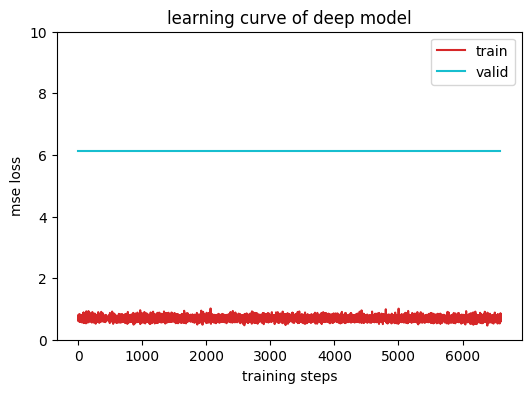

In [ ]:
plot_learning_curve(model_loss_record, title='deep model')

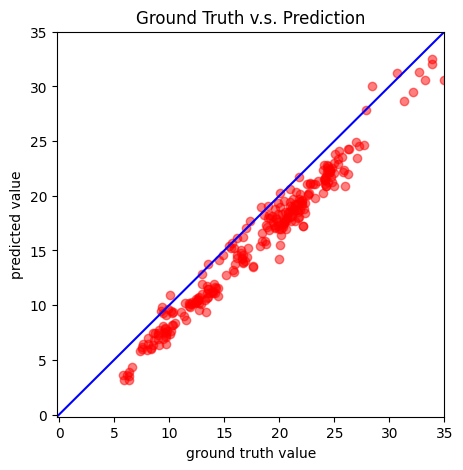

In [ ]:
del model
model = DNN_Covid19(train_loader.dataset.dim).to(device)
ckpt = torch.load("./model.pth", map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)
plot_pred(valid_loader, model, device)  # Show prediction on the validation set

# **Reference**
This code is completely written by Heng-Jui Chang @ NTUEE.  
Copying or reusing this code is required to specify the original author.

E.g.  
Source: Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)
